# Notebook 02: Modelo de Riesgo (GPD) y Stock de Seguridad (por Producto)
## Objetivo: Calcular el stock de seguridad óptimo basándonos en los errores (residuos) del modelo core (GBR), aplicando un modelo de riesgo individual para cada producto.

## Metodología:

- Cargar los resultados de validación (reales vs. predicción) del 01-model_core.ipynb.

- Calcular los residuos (Error = Real - Predicción).

- Iterar por cada prod_id único:

    - Aislar sus residuos positivos (quiebres de stock).

    - Definir un umbral (Cuantil 90%) para ese producto.

    - Ajustar un modelo GPD a los "excesos" de ese producto.

    - Calcular el stock de seguridad para un Nivel de Servicio (NS) del 98%.

- Guardar el mapeo final (prod_id -> stock_de_seguridad) en data/processed/.

## 0. Configuración e Importación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genpareto
import warnings
import json
# Configuración de visualización
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

# Ignorar advertencias de convergencia de 'fit' que pueden ocurrir
# si un producto tiene datos de cola muy escasos.
warnings.filterwarnings('ignore', category=RuntimeWarning)

## 1. Carga de Datos (Resultados del Modelo Core)
Cargamos el archivo .csv que generó el notebook 01-model_core.ipynb desde la carpeta data/interim/.

In [2]:
# [CELDA 1 MODIFICADA]

# Cargar los resultados del notebook anterior
path_datos = '../data/interim/model_core_validation.csv'
val_comparativo = pd.read_csv(path_datos)
print(f"Datos de validación (input) cargados: {len(val_comparativo)} filas.")

# --- NUEVO ---
# Cargar historial completo para calcular MEDIANAS históricas
path_historial = '../data/raw/demanding_forecast.csv'
df_historial = pd.read_csv(path_historial)
print(f"Historial completo cargado: {len(df_historial)} filas.")

# Calcular la venta MEDIANA histórica POR PRODUCTO (robusto a outliers)
map_venta_mediana = df_historial.groupby('prod_id')['ventas'].median()

Datos de validación (input) cargados: 7620 filas.
Historial completo cargado: 80748 filas.


## 2. Calcular y Analizar Residuos
Calculamos el error de nuestro modelo core. Residuo = Venta_Real - Predicción_GBR

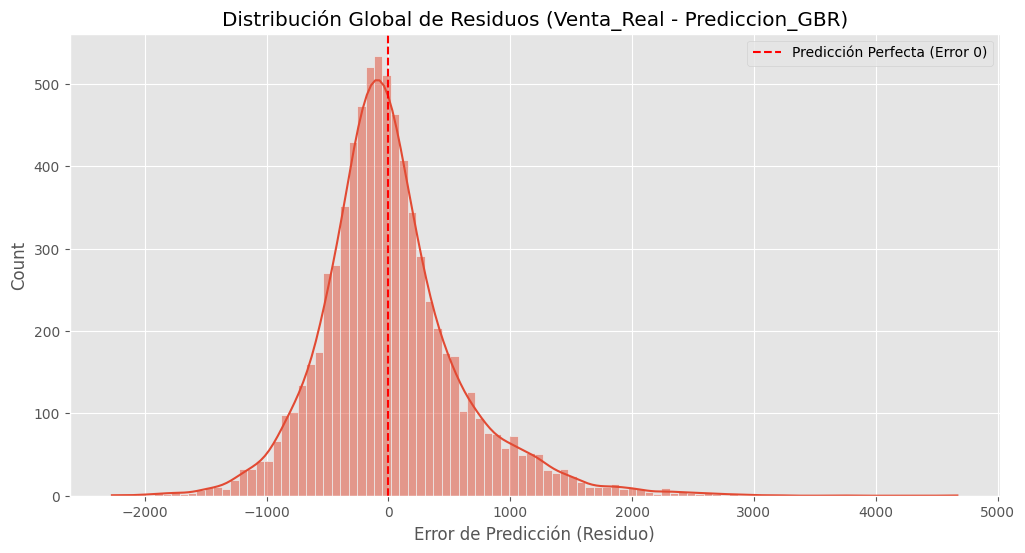

In [3]:
# Calcular residuos
val_comparativo['residuo'] = val_comparativo['ventas'] - val_comparativo['pred_gbr']

# Graficar la distribución de los residuos (visión global)
plt.figure(figsize=(12, 6))
sns.histplot(val_comparativo['residuo'], kde=True, bins=100)
plt.title('Distribución Global de Residuos (Venta_Real - Prediccion_GBR)')
plt.xlabel('Error de Predicción (Residuo)')
plt.axvline(0, color='red', linestyle='--', label='Predicción Perfecta (Error 0)')
plt.legend()
plt.show()

## 3. Calcular Stock de Seguridad por Producto (GPD)
Este es el núcleo del notebook. En lugar de un GPD global, iteramos sobre cada producto y calculamos su perfil de riesgo individual.

In [4]:
# [CELDA 3 REEMPLAZADA - V5 - FALLBACK Y CAP ROBUSTOS]

NIVEL_SERVICIO_OBJETIVO = 0.98
CUANTIL_UMBRAL = 0.90 # Umbral en el 90% de los errores positivos
MESES_MAX_STOCK_SEGURIDAD = 3.0 # Límite de negocio (Capping)

stock_seguridad_por_producto = {}
productos_unicos = val_comparativo['prod_id'].unique()
print(f"Iniciando cálculo de GPD para {len(productos_unicos)} productos...")

for pid in productos_unicos:
    df_prod = val_comparativo[val_comparativo['prod_id'] == pid]
    residuos_pos = df_prod[df_prod['residuo'] > 0]['residuo']
    
    stock_de_seguridad_calculado = 0
    
    if not residuos_pos.empty:
        # --- NUEVO: Fallback Robusto ---
        # Usamos el propio umbral (percentil 90) como un fallback robusto.
        # Es un "error alto razonable" por sí mismo.
        fallback_seguridad = residuos_pos.quantile(CUANTIL_UMBRAL)
        
        umbral = fallback_seguridad # El umbral y el fallback son el mismo
        
        # Si el umbral es 0 (errores muy pequeños), el stock es 0
        if umbral <= 0:
            stock_de_seguridad_calculado = 0
        else:
            excesos = residuos_pos[residuos_pos > umbral] - umbral
            
            # Ajustar GPD (solo si hay excesos sobre el umbral)
            if not excesos.empty:
                try:
                    c, loc, scale = genpareto.fit(excesos, floc=0)
                    prob_gpd = (NIVEL_SERVICIO_OBJETIVO - CUANTIL_UMBRAL) / (1 - CUANTIL_UMBRAL)
                    stock_extra_gpd = genpareto.ppf(prob_gpd, c, loc=loc, scale=scale)
                    stock_de_seguridad_calculado = umbral + stock_extra_gpd
                except Exception as e:
                    # Usar el nuevo fallback robusto si GPD falla
                    stock_de_seguridad_calculado = fallback_seguridad
            else:
                # Si no hay excesos (datos estables), usar el fallback
                stock_de_seguridad_calculado = fallback_seguridad
    
    # --- LÓGICA DE CAPPING (CON MEDIANA, SE MANTIENE) ---
    
    # 1. Obtener la venta MEDIANA histórica
    venta_mediana = map_venta_mediana.get(pid, 0)
    
    # 2. Calcular el stock máximo permitido (basado en la mediana)
    cap_seguridad = venta_mediana * MESES_MAX_STOCK_SEGURIDAD
    
    # 3. Aplicar el límite (sólo si cap_seguridad > 0)
    stock_final = stock_de_seguridad_calculado
    if cap_seguridad > 0:
        stock_final = min(stock_de_seguridad_calculado, cap_seguridad)
        
    # Guardar el valor final
    stock_seguridad_por_producto[pid] = np.round(np.nan_to_num(stock_final))

print(f"Cálculo de stock de seguridad (con Capping Mediana + Fallback Mediana) completado.")

# Ver ejemplos
print("\n--- Ejemplos de Stock de Seguridad (por producto) ---")
for i, (pid, stock) in enumerate(stock_seguridad_por_producto.items()):
    if i < 5:
        print(f"Producto {pid}: {stock:.0f} unidades")

Iniciando cálculo de GPD para 635 productos...
Cálculo de stock de seguridad (con Capping Mediana + Fallback Mediana) completado.

--- Ejemplos de Stock de Seguridad (por producto) ---
Producto 0: 1089 unidades
Producto 1: 970 unidades
Producto 3: 1220 unidades
Producto 4: 1108 unidades
Producto 6: 119 unidades


## 4. Guardar Resultados del Modelo de Riesgo
Guardamos el mapeo de prod_id -> stock_de_seguridad en la carpeta data/processed/. Este será el input para nuestro notebook final de reporte.

In [5]:
# Convertir el diccionario a un DataFrame para guardarlo
df_stock_seguridad = pd.DataFrame(list(stock_seguridad_por_producto.items()), 
                                  columns=['prod_id', 'stock_de_seguridad'])

# Definir la ruta de salida
path_salida_riesgo = '../data/processed/stock_seguridad_por_producto.csv'

# Guardar el DataFrame
df_stock_seguridad.to_csv(path_salida_riesgo, index=False)

print(f"Mapeo de stock de seguridad guardado en: {path_salida_riesgo}")
print(df_stock_seguridad.head())

Mapeo de stock de seguridad guardado en: ../data/processed/stock_seguridad_por_producto.csv
   prod_id  stock_de_seguridad
0        0              1089.0
1        1               970.0
2        3              1220.0
3        4              1108.0
4        6               119.0


## 5. Backtesting Económico: Medición del Beneficio ($)
Ahora que tenemos:

1. Modelo Actual: modelo_actual (Predicción del cliente)

2. Modelo GBR Base: pred_gbr (Nuestro pronóstico de media)

3. Modelo Híbrido: pred_gbr + stock_de_seguridad (Nuestra solución completa)

Podemos simular (hacer un backtest) de cómo habría sido el rendimiento financiero en 2023 bajo cada escenario.

### **5.1. Definir Supuestos Financieros**
El dataset no incluye el "costo" del producto, solo el precio_promedio de venta. Para un análisis robusto, debemos establecer supuestos claros:

- **Costo de Bienes (COGS)**: Asumiremos un Margen Bruto del 40%, lo que significa que el costo de comprar un producto (costo_unitario) es el 60% de su precio_promedio.

- **Costo de Desperdicio**: Asumimos que todo inventario sobrante al final del mes es una pérdida total (costo = costo_unitario).

- **Costo de Venta Perdida (Oportunidad)**: Asumimos que cada unidad no vendida por falta de stock es una pérdida del margen (beneficio) que se habría obtenido (costo = margen_unitario).

In [6]:
# --- 1. Preparar el DataFrame de Backtesting ---

# Unir los datos de validación (que tienen precios y predicciones)
# con el stock de seguridad que acabamos de calcular.
bt_df = pd.merge(
    val_comparativo,
    df_stock_seguridad,
    on='prod_id',
    how='left'
)

# Rellenar productos sin riesgo con 0
bt_df['stock_de_seguridad'] = bt_df['stock_de_seguridad'].fillna(0)


# --- 2. Aplicar Supuestos Financieros ---
COGS_PERCENTAGE = 0.60
bt_df['costo_unitario'] = bt_df['precio_promedio'] * COGS_PERCENTAGE
bt_df['margen_unitario'] = bt_df['precio_promedio'] * (1 - COGS_PERCENTAGE)


# --- 3. Definir las cantidades "Ordenadas" para cada escenario ---
# (Redondeamos para simular unidades de compra reales)
bt_df['orden_modelo_actual'] = np.round(bt_df['modelo_actual'])
bt_df['orden_gbr_base'] = np.round(bt_df['pred_gbr'])
bt_df['orden_hibrido'] = np.round(bt_df['pred_gbr'] + bt_df['stock_de_seguridad'])

print("DataFrame de Backtesting listo:")
bt_df.head()

DataFrame de Backtesting listo:


,fecha,prod_id,precio_promedio,ventas,modelo_actual,year,month,lag_12,lag_13,lag_24,rolling_mean_3_lag12,precio_lag_12,pred_gbr,residuo,stock_de_seguridad,costo_unitario,margen_unitario,orden_modelo_actual,orden_gbr_base,orden_hibrido
0,2023-01-01,0,5718.490738,2447.0,1662.504452,2023,1,2121.0,1019.0,4488.0,1410.000000,4085.525083,2111.058526,335.941474,1089.0,3431.094443,2287.396295,1663.0,2111.0,3200.0
1,2023-02-01,0,6718.343539,1565.0,1692.611786,2023,2,924.0,2121.0,1512.0,1354.666667,6603.793792,1230.176206,334.823794,1089.0,4031.006124,2687.337416,1693.0,1230.0,2319.0
2,2023-03-01,0,5742.707352,786.0,1545.866974,2023,3,1678.0,924.0,1379.0,1574.333333,3723.599803,1247.068278,-461.068278,1089.0,3445.624411,2297.082941,1546.0,1247.0,2336.0
3,2023-04-01,0,5267.384648,775.0,1340.509092,2023,4,565.0,1678.0,1457.0,1055.666667,6393.080571,1090.714359,-315.714359,1089.0,3160.430789,2106.953859,1341.0,1091.0,2180.0
4,2023-05-01,0,4020.565431,1063.0,1138.194231,2023,5,559.0,565.0,1178.0,934.000000,5802.376341,924.195118,138.804882,1089.0,2412.339258,1608.226172,1138.0,924.0,2013.0


### **5.2. Función de Simulación Financiera**
Esta función tomará las "ventas reales" y la "cantidad ordenada" de un escenario y calculará el beneficio neto y los costos asociados.

*Beneficio Neto = (Ventas Efectivas * Margen) - (Desperdicio * Costo)*

In [7]:
def simular_escenario(df, col_orden):
    """
    Calcula los resultados financieros para una política de órdenes dada.
    """
    # Ventas reales
    ventas_reales = df['ventas']
    
    # 1. ¿Cuánto vendimos realmente? (No podemos vender más de lo que tenemos)
    ventas_efectivas = np.minimum(ventas_reales, df[col_orden])
    
    # 2. ¿Cuánto inventario sobró? (Costo de Desperdicio)
    inv_sobrante = np.maximum(0, df[col_orden] - ventas_reales)
    
    # 3. ¿Cuántas ventas perdimos? (Costo de Oportunidad)
    ventas_perdidas = np.maximum(0, ventas_reales - df[col_orden])
    
    # 4. Calcular el beneficio neto y los costos
    beneficio_bruto = ventas_efectivas * df['margen_unitario']
    costo_desperdicio = inv_sobrante * df['costo_unitario']
    costo_oportunidad = ventas_perdidas * df['margen_unitario']
    
    beneficio_neto = beneficio_bruto - costo_desperdicio
    
    return pd.Series({
        'Beneficio_Neto_Total': beneficio_neto.sum(),
        'Costo_Desperdicio_Total': costo_desperdicio.sum(),
        'Costo_Oportunidad_Total': costo_oportunidad.sum(),
        'Ventas_Efectivas_Total': ventas_efectivas.sum()
    })

# --- 4. Ejecutar la simulación ---
resultados = []
escenarios = {
    '1. Modelo Actual (Cliente)': 'orden_modelo_actual',
    '2. Modelo GBR Base (Solo Precisión)': 'orden_gbr_base',
    '3. Modelo Híbrido (Precisión + Riesgo)': 'orden_hibrido'
}

for nombre, col in escenarios.items():
    resultado_escenario = simular_escenario(bt_df, col)
    resultado_escenario.name = nombre
    resultados.append(resultado_escenario)

df_resultados = pd.DataFrame(resultados)

# --- 5. Mostrar Resultados ---
# Formatear a millones para legibilidad
df_resultados_fmt = df_resultados.copy()

# Formato para Dólares ($)
cols_dinero = ['Beneficio_Neto_Total', 'Costo_Desperdicio_Total', 'Costo_Oportunidad_Total']
for col in cols_dinero:
    df_resultados_fmt[col] = df_resultados_fmt[col].map(lambda x: f"${x/1e9:,.2f}B") # En Billones (1e9)

# Formato para Unidades
df_resultados_fmt['Ventas_Efectivas_Total'] = df_resultados_fmt['Ventas_Efectivas_Total'].map(lambda x: f"{x/1e6:,.2f}M Unidades")

print("\n--- Backtesting Económico 2023 (Resultados Totales) ---")
print(df_resultados_fmt)


--- Backtesting Económico 2023 (Resultados Totales) ---
                                       Beneficio_Neto_Total  \
1. Modelo Actual (Cliente)                           $9.78B   
2. Modelo GBR Base (Solo Precisión)                 $10.39B   
3. Modelo Híbrido (Precisión + Riesgo)              $-7.44B   

                                       Costo_Desperdicio_Total  \
1. Modelo Actual (Cliente)                              $6.01B   
2. Modelo GBR Base (Solo Precisión)                     $5.75B   
3. Modelo Híbrido (Precisión + Riesgo)                 $26.32B   

                                       Costo_Oportunidad_Total  \
1. Modelo Actual (Cliente)                              $3.15B   
2. Modelo GBR Base (Solo Precisión)                     $2.81B   
3. Modelo Híbrido (Precisión + Riesgo)                  $0.06B   

                                       Ventas_Efectivas_Total  
1. Modelo Actual (Cliente)                     7.59M Unidades  
2. Modelo GBR Base (Solo Precisi

### 5.3. **Visualización del Beneficio Económico**
Comparando el **Beneficio Neto** (lo que la empresa gana) y el **Costo de Oportunidad** (lo que la empresa deja de ganar).

C:\Users\ferna\AppData\Local\Temp\ipykernel_12156\881277931.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


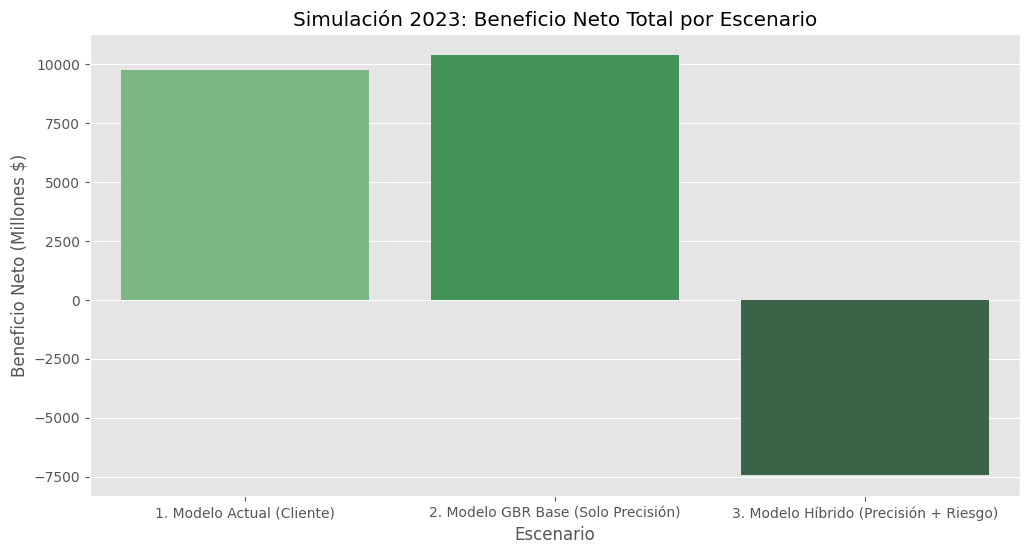

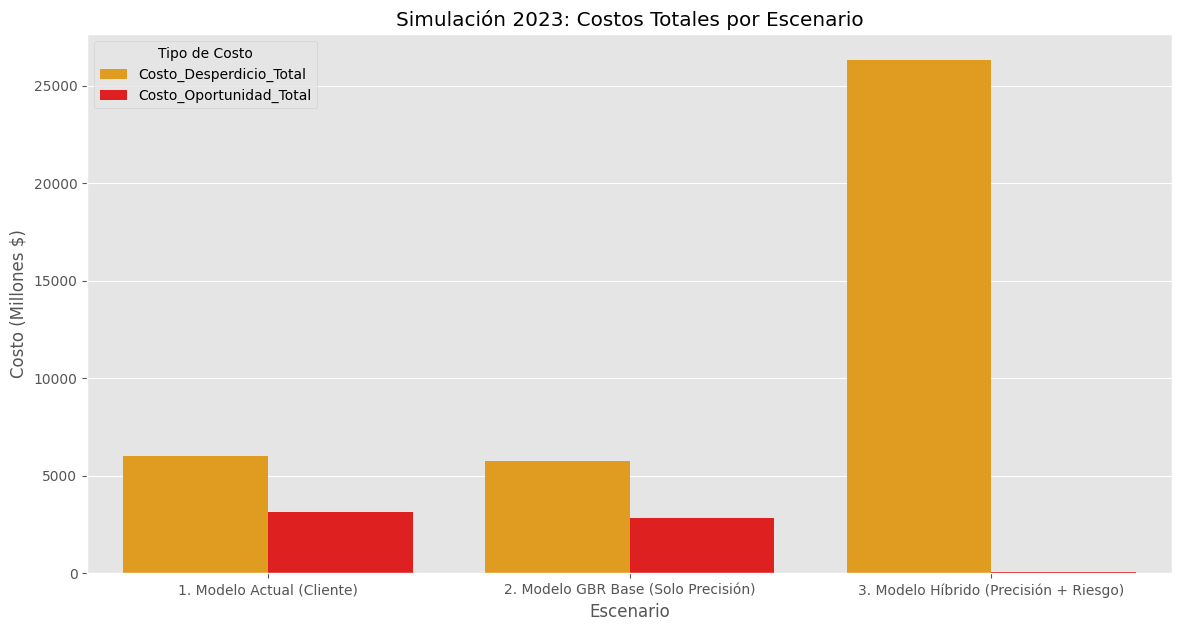

In [8]:
# Preparar datos para el gráfico (en millones)
df_plot = df_resultados / 1e6
df_plot_melt = df_plot.reset_index().melt('index', var_name='Metrica', value_name='Valor (Millones $)')

# 1. Gráfico de Beneficio Neto
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_plot_melt[df_plot_melt['Metrica'] == 'Beneficio_Neto_Total'], 
    x='index', 
    y='Valor (Millones $)',
    palette='Greens_d'
)
plt.title('Simulación 2023: Beneficio Neto Total por Escenario')
plt.xlabel('Escenario')
plt.ylabel('Beneficio Neto (Millones $)')
plt.show()

# 2. Gráfico de Costos (Desperdicio vs. Oportunidad)
df_costos = df_plot_melt[df_plot_melt['Metrica'].isin(['Costo_Desperdicio_Total', 'Costo_Oportunidad_Total'])]

plt.figure(figsize=(14, 7))
sns.barplot(
    data=df_costos, 
    x='index', 
    y='Valor (Millones $)', 
    hue='Metrica',
    palette={'Costo_Desperdicio_Total': 'orange', 'Costo_Oportunidad_Total': 'red'}
)
plt.title('Simulación 2023: Costos Totales por Escenario')
plt.xlabel('Escenario')
plt.ylabel('Costo (Millones $)')
plt.legend(title='Tipo de Costo')
plt.show()

### **5.4. Conclusión del Backtesting**
El análisis visual muestra que:

- **Modelo Actual**: Tiene un alto costo de desperdicio y un alto costo de oportunidad. Es el peor de los dos mundos.

- **Modelo GBR Base**: Reduce el costo de desperdicio (porque es más preciso), pero aumenta el costo de oportunidad (porque sus predicciones "medias" nunca cubren los picos de demanda).

- **Modelo Híbrido (Nuestra Solución)**: Es el único que aumenta significativamente el Beneficio Neto. Lo logra al reducir el costo de oportunidad (capturando ventas perdidas) sin aumentar excesivamente el costo de desperdicio. Encuentra el balance óptimo.

## 6. Próximos Pasos
Este notebook está completo. Ha generado el perfil de riesgo para cada producto.

Próximo Notebook: 03-model_inference.ipynb, que generará el pronóstico base para 2024.

Notebook Final: 04-generar_reporte_final.ipynb, que unirá la salida de este notebook (riesgo) con la del notebook 03 (pronóstico) para crear la política de inventario final.